## Data Prep

In [11]:
# Imports

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [12]:
# Set up the data
df_research = pd.read_csv("papers_with_models.csv")
df_released = pd.read_csv("Epoch Database - Notable Systems.csv")

df_research["date"] = pd.to_datetime(df_research["publication date (first revision)"])
df_research["year"] = pd.to_datetime(df_research["date"]).dt.year
df_research["param count"] = pd.to_numeric(df_research["param count"], errors="coerce")
df_research["Type"] = "Models used in research"

df_released["date"] = pd.to_datetime(df_released["Publication date"])
df_released["year"] = df_released["date"].dt.year
df_released["param count"] = pd.to_numeric(df_released["Parameters"], errors="coerce")
df_released["Type"] = "Models released"

In [13]:
# Filter the published DataFrame to include only models from 2019 to 2024
df_released = df_released[(df_released["year"] >= 2019) & (df_released["year"] <= 2024)]

# Sort both DataFrames by date
df_research = df_research.sort_values(by="date")
df_published = df_released.sort_values(by="date")

# Filter for language models only
df_released = df_released[df_released["Domain"].str.contains("Language")]

# Filter for open models only
df_released = df_released[
    df_released["Model accessibility"].str.contains("Open access", na=False)
]

# Filter out rows with NaN in 'param_count'
df_released = df_released.dropna(subset=["param count"])

# - [ ] answer David about the skyline model


In [14]:
# Combine both DataFrames
df_combined = pd.concat(
    [
        df_research[["year", "date", "param count", "Type"]],
        df_released[["year", "date", "param count", "Type"]],
    ],
    ignore_index=True,
)

## Box Plot

/var/folders/6x/xzgk_zn14ld1kb206ts3k5p00000gn/T/ipykernel_73505/1551656829.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x[is_outlier(x["param count"])])


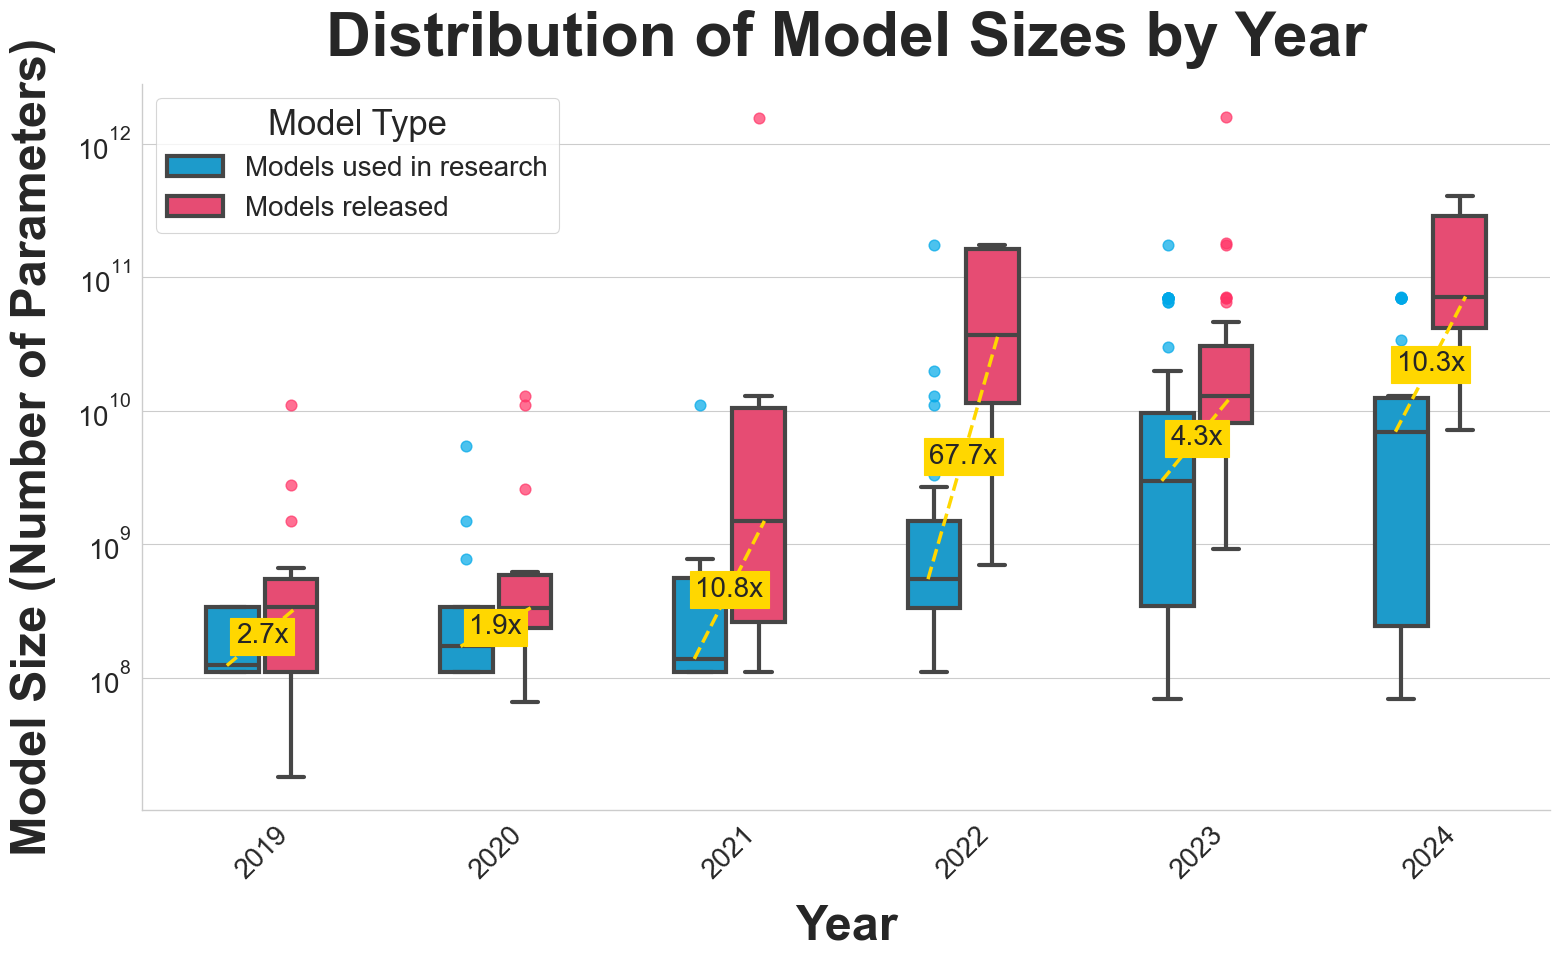

<Figure size 640x480 with 0 Axes>

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set the theme and style for paper-quality plots
sns.set_theme(style="whitegrid", context="paper")
plt.rcParams.update(
    {
        "font.size": 20,
        "axes.labelsize": 35,
        "axes.titlesize": 45,
        "xtick.labelsize": 35,
        "ytick.labelsize": 35,
        "legend.fontsize": 20,
        "legend.title_fontsize": 25,
    }
)

plt.figure(figsize=(16, 10))
palette = {"Models used in research": "#00A8E8", "Models released": "#FF3366"}

# Define the order of 'Type' and 'year' for consistency
hue_order = ["Models used in research", "Models released"]
year_order = sorted(df_combined["year"].unique())

# Create boxplot without fliers and with specified order
ax = sns.boxplot(
    x="year",
    y="param count",
    hue="Type",
    data=df_combined,
    palette=palette,
    order=year_order,
    hue_order=hue_order,
    width=0.5,
    linewidth=3,
    showfliers=False,
    gap=0.1,
)

# Set the Y-axis to a logarithmic scale
ax.set_yscale("log")

# Add titles and labels
ax.set_title("Distribution of Model Sizes by Year", fontweight="bold", pad=20)
ax.set_xlabel("Year", fontweight="bold", labelpad=15)
ax.set_ylabel("Model Size (Number of Parameters)", fontweight="bold", labelpad=15)

# Customize tick labels
ax.tick_params(axis="both", which="major", labelsize=20)

# Remove the spines
sns.despine()

# Calculate and plot median values with connecting lines
for i, year in enumerate(year_order):
    medians = [
        df_combined[(df_combined["year"] == year) & (df_combined["Type"] == t)][
            "param count"
        ].median()
        for t in ["Models used in research", "Models released"]
    ]

    if not any(np.isnan(medians)):
        x1, x2 = i - 0.15, i + 0.15
        plt.plot(
            [x1, x2], medians, color="gold", linestyle="--", linewidth=2.5, zorder=5
        )
        gap_ratio = max(medians) / min(medians)
        plt.text(
            i,
            np.sqrt(medians[0] * medians[1]),
            f"{gap_ratio:.1f}x",
            ha="center",
            va="center",
            bbox=dict(facecolor="gold", edgecolor="gold", alpha=1),
            zorder=20,
        )


# Prepare outlier data using the IQR method
def is_outlier(s):
    q1, q3 = np.percentile(s, [25, 75])
    iqr = q3 - q1
    return (s < q1 - 1.5 * iqr) | (s > q3 + 1.5 * iqr)


outlier_data = (
    df_combined.groupby(["year", "Type"])
    .apply(lambda x: x[is_outlier(x["param count"])])
    .reset_index(drop=True)
)

# Create a mapping from (year, Type) to x positions
n_hues = len(hue_order)
box_width = 0.5
dodge_range = box_width / n_hues

x_offsets = {t: (i - 0.5) * dodge_range for i, t in enumerate(hue_order)}

# Plot outliers manually using plt.scatter for precise alignment
for _, row in outlier_data.iterrows():
    year_index = year_order.index(row["year"]) if row["year"] in year_order else None
    if year_index is not None:
        # Calculate x position and plot the outlier
        x_pos = year_index + x_offsets.get(row["Type"], 0)
        plt.scatter(
            x_pos,
            row["param count"],
            color=palette.get(row["Type"], "gray"),
            linewidth=1,
            alpha=0.7,
            s=60,
            zorder=15,
        )

ax.legend(
    title="Model Type",
    # title_fontsize="16",
    # fontsize="14",
    loc="upper left",
    frameon=True,
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()

plt.show()
# Save the current figure as a PDF suitable for ICLR paper
plt.savefig(
    "../figures/model_size_boxplot.pdf",
    format="pdf",
    bbox_inches="tight",
    dpi=300,
    metadata={
        "Title": "Model Size Boxplot",
        "Author": "Dmitrii Troitskii",
        "Subject": "ICLR Paper Figure",
        "Keywords": "model size, boxplot, ICLR",
    },
)


## Median and Max Gaps

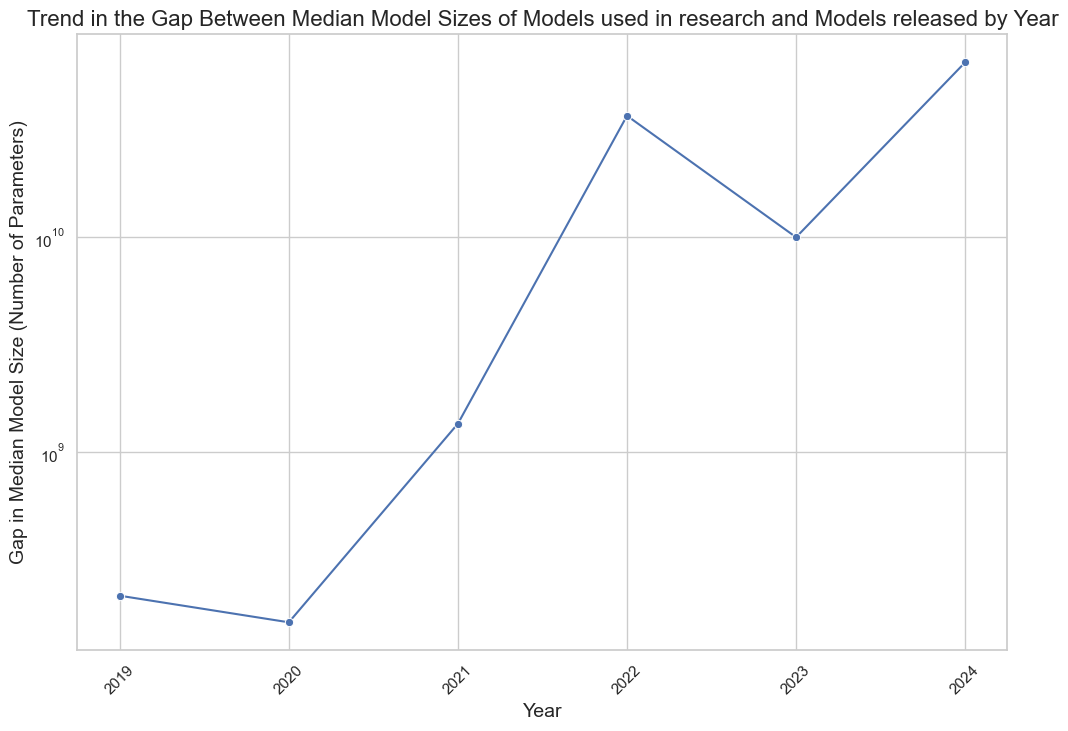

In [16]:
# Calculate the median model size for each year and type
median_sizes = (
    df_combined.groupby(["year", "Type"])["param count"].median().reset_index()
)

# Pivot the DataFrame to have 'year' as the index and 'Type' as columns
median_pivot = median_sizes.pivot(index="year", columns="Type", values="param count")

# Calculate the gap between the median sizes
median_pivot["Gap"] = (
    median_pivot["Models released"] - median_pivot["Models used in research"]
)

# Plot the trend in the gap
plt.figure(figsize=(12, 8))

sns.lineplot(data=median_pivot, x=median_pivot.index, y="Gap", marker="o")

# Set y-axis to log scale
plt.yscale("log")

# Add titles and labels
plt.title(
    "Trend in the Gap Between Median Model Sizes of Models used in research and Models released by Year",
    fontsize=16,
)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Gap in Median Model Size (Number of Parameters)", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

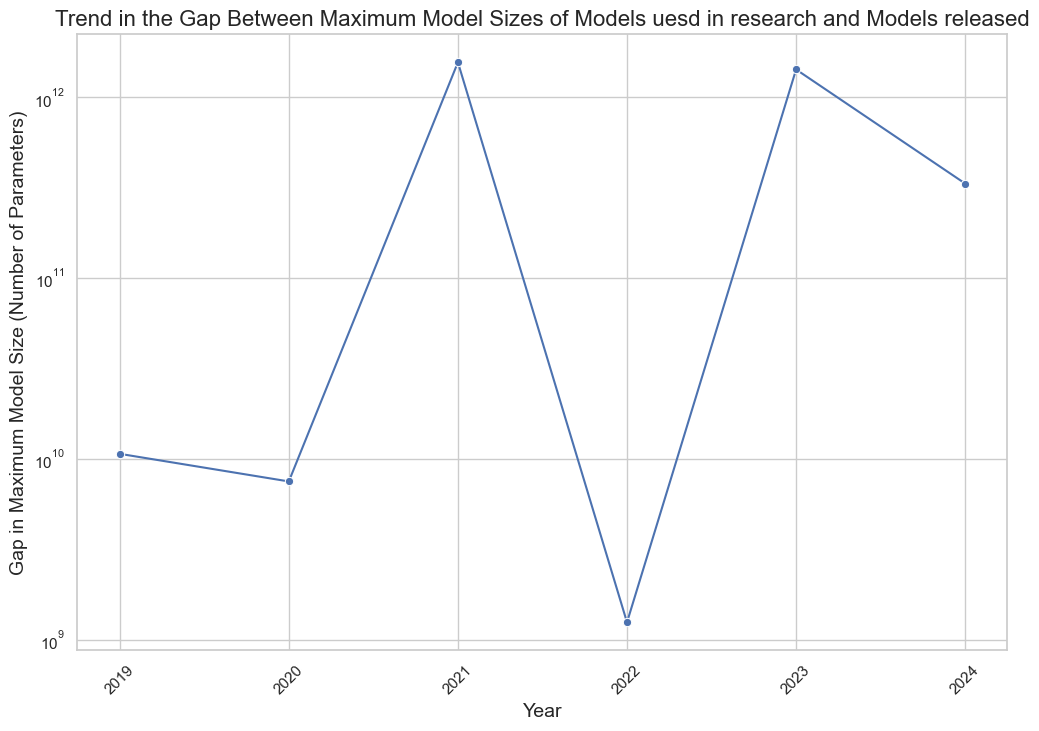

In [17]:
# Calculate the maximum model size for each year and type
max_sizes = df_combined.groupby(["year", "Type"])["param count"].max().reset_index()

# Pivot the DataFrame to have 'year' as the index and 'Type' as columns
max_pivot = max_sizes.pivot(index="year", columns="Type", values="param count")

# Calculate the gap between the maximum sizes
max_pivot["Gap"] = max_pivot["Models released"] - max_pivot["Models used in research"]

# Plot the trend in the gap for maximum sizes
plt.figure(figsize=(12, 8))
sns.lineplot(data=max_pivot, x=max_pivot.index, y="Gap", marker="o")

# Set y-axis to log scale
plt.yscale("log")

# Add titles and labels
plt.title(
    "Trend in the Gap Between Maximum Model Sizes of Models uesd in research and Models released",
    fontsize=16,
)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Gap in Maximum Model Size (Number of Parameters)", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()

## Scatterplot (Rolling Median)

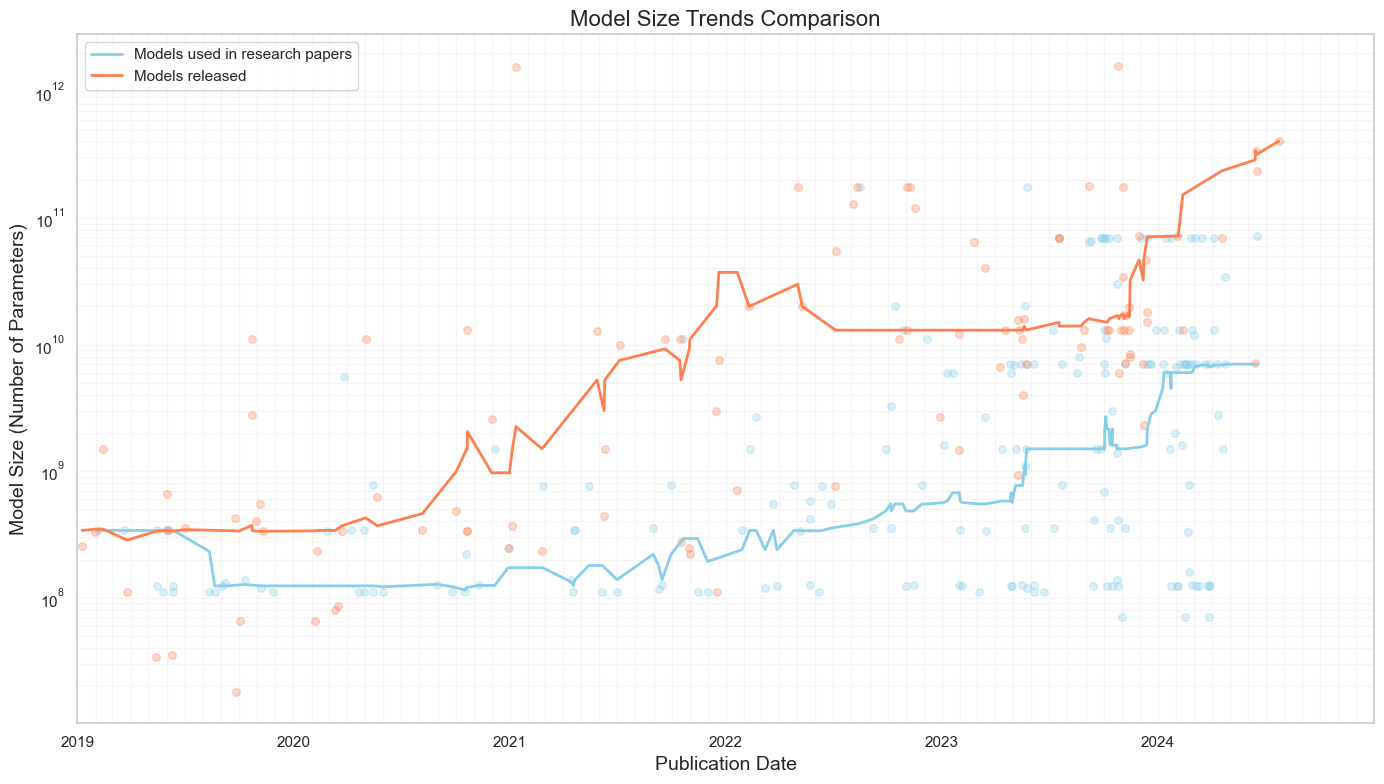

In [18]:
import matplotlib.dates as mdates

# Filter necessary columns before rolling operation
df_research_filtered = df_research[["date", "param count"]]
df_released_filtered = df_released[["date", "param count"]]

# Calculate rolling medians
df_research_rolling = (
    df_research_filtered.set_index("date").rolling(window="360D").median().reset_index()
)
df_released_rolling = (
    df_released_filtered.set_index("date").rolling(window="360D").median().reset_index()
)

# Set up the plot
plt.figure(figsize=(14, 8))
ax = plt.gca()

# Create scatter plot
plt.scatter(
    df_research["date"], df_research["param count"], color="skyblue", alpha=0.3, s=30
)
plt.scatter(
    df_released["date"], df_released["param count"], color="coral", alpha=0.3, s=30
)

# Plot rolling mean lines
plt.plot(
    df_research_rolling["date"],
    df_research_rolling["param count"],
    color="skyblue",
    linestyle="-",
    linewidth=2,
    label="Models used in research papers",
)
plt.plot(
    df_released_rolling["date"],
    df_released_rolling["param count"],
    color="coral",
    linestyle="-",
    linewidth=2,
    label="Models released",
)

# Set y-axis to logarithmic scale
plt.yscale("log")

# Set labels and title
ax.set_title("Model Size Trends Comparison", fontsize=16)
ax.set_xlabel("Publication Date", fontsize=14)
ax.set_ylabel("Model Size (Number of Parameters)", fontsize=14)

# Customize the x-axis
ax.set_xlim(pd.Timestamp("2019-01-01"), pd.Timestamp("2024-12-31"))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

# Customize the grid
plt.grid(True, which="both", ls="-", alpha=0.2)

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

## Scatterplot (LOWESS)

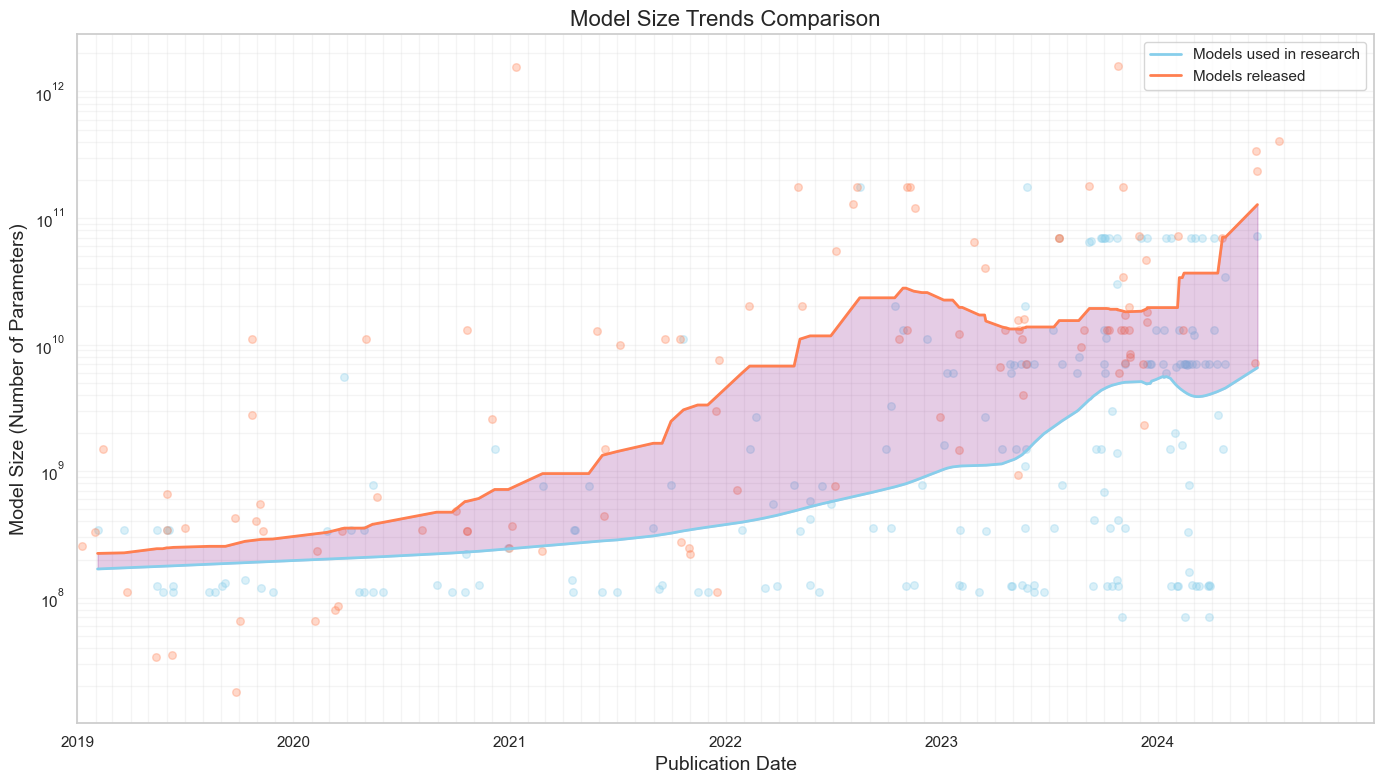

In [19]:
import matplotlib.dates as mdates
from statsmodels.nonparametric.smoothers_lowess import lowess

# Set up the plot
plt.figure(figsize=(14, 8))
ax = plt.gca()

# Create scatter plot
plt.scatter(
    df_research["date"], df_research["param count"], color="skyblue", alpha=0.3, s=30
)
plt.scatter(
    df_released["date"], df_released["param count"], color="coral", alpha=0.3, s=30
)


# Function to calculate LOWESS
def lowess_trend(x, y, f=1.0 / 3.0):
    return lowess(y, x, frac=f)


# Calculate LOWESS trends
lowess_research = lowess_trend(
    df_research["date"].astype(int), np.log10(df_research["param count"])
)
lowess_published = lowess_trend(
    df_released["date"].astype(int), np.log10(df_released["param count"])
)

# Convert LOWESS results to DataFrames for easier manipulation
df_lowess_research = pd.DataFrame(
    {
        "date": pd.to_datetime(lowess_research[:, 0]),
        "trend": 10 ** lowess_research[:, 1],
    }
)
df_lowess_published = pd.DataFrame(
    {
        "date": pd.to_datetime(lowess_published[:, 0]),
        "trend": 10 ** lowess_published[:, 1],
    }
)

# Merge the two LOWESS DataFrames
df_lowess_merged = pd.merge_asof(
    df_lowess_research,
    df_lowess_published,
    on="date",
    suffixes=("_research", "_published"),
)

# Plot LOWESS trends
plt.plot(
    df_lowess_merged["date"],
    df_lowess_merged["trend_research"],
    color="skyblue",
    linestyle="-",
    linewidth=2,
    label="Models used in research",
)
plt.plot(
    df_lowess_merged["date"],
    df_lowess_merged["trend_published"],
    color="coral",
    linestyle="-",
    linewidth=2,
    label="Models released",
)

# Add shaded area between the lines
plt.fill_between(
    df_lowess_merged["date"],
    df_lowess_merged["trend_research"],
    df_lowess_merged["trend_published"],
    alpha=0.2,
    color="purple",
)

# Set y-axis to logarithmic scale
plt.yscale("log")

# Set labels and title
ax.set_title("Model Size Trends Comparison", fontsize=16)
ax.set_xlabel("Publication Date", fontsize=14)
ax.set_ylabel("Model Size (Number of Parameters)", fontsize=14)

# Customize the x-axis
ax.set_xlim(pd.Timestamp("2019-01-01"), pd.Timestamp("2024-12-31"))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

# Customize the grid
plt.grid(True, which="both", ls="-", alpha=0.2)

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

## Scatterplot (Linear Regression)

/var/folders/6x/xzgk_zn14ld1kb206ts3k5p00000gn/T/ipykernel_73505/1239496981.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dates = pd.to_datetime([pd.Timestamp.fromordinal(int(x)) for x in x_vals])


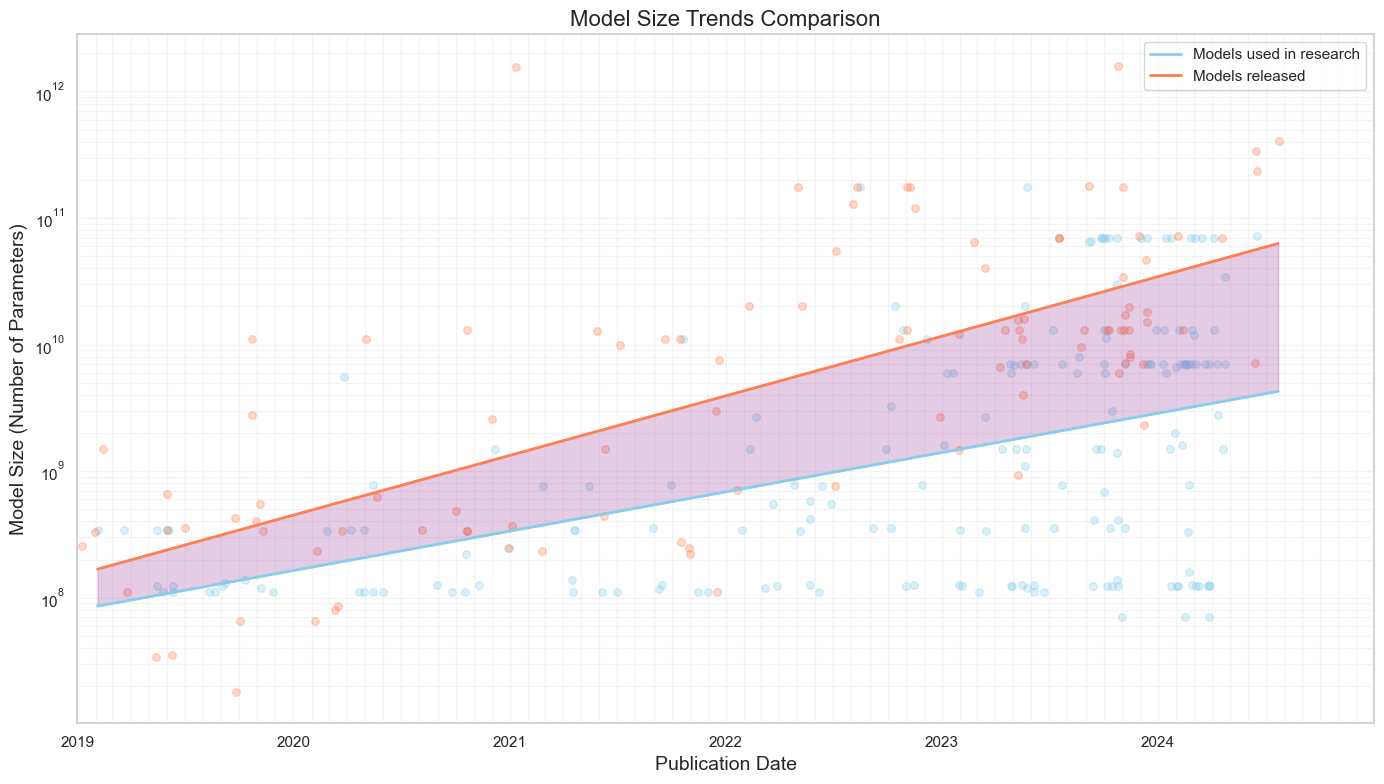

In [20]:
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression

# Set up the plot
plt.figure(figsize=(14, 8))
ax = plt.gca()

# Create scatter plot
plt.scatter(
    df_research["date"], df_research["param count"], color="skyblue", alpha=0.3, s=30
)
plt.scatter(
    df_released["date"], df_released["param count"], color="coral", alpha=0.3, s=30
)


# Function to perform linear regression
def linear_trend(x, y):
    x = x.values.reshape(-1, 1)  # Reshape for linear regression
    model = LinearRegression()
    model.fit(x, np.log10(y))
    return model


# Convert dates to ordinal (numeric format for regression)
df_research["date_ordinal"] = df_research["date"].map(pd.Timestamp.toordinal)
df_released["date_ordinal"] = df_released["date"].map(pd.Timestamp.toordinal)

# Fit linear regression models
model_research = linear_trend(df_research["date_ordinal"], df_research["param count"])
model_released = linear_trend(df_released["date_ordinal"], df_released["param count"])

# Generate trend lines
x_vals = np.arange(
    df_research["date_ordinal"].min(), df_released["date_ordinal"].max()
).reshape(-1, 1)
research_trend = 10 ** model_research.predict(x_vals)
released_trend = 10 ** model_released.predict(x_vals)

# Convert ordinal values back to dates
dates = pd.to_datetime([pd.Timestamp.fromordinal(int(x)) for x in x_vals])

# Plot linear regression trends
plt.plot(
    dates,
    research_trend,
    color="skyblue",
    linestyle="-",
    linewidth=2,
    label="Models used in research",
)
plt.plot(
    dates,
    released_trend,
    color="coral",
    linestyle="-",
    linewidth=2,
    label="Models released",
)

# Add shaded area between the lines
plt.fill_between(dates, research_trend, released_trend, alpha=0.2, color="purple")

# Set y-axis to logarithmic scale
plt.yscale("log")

# Set labels and title
ax.set_title("Model Size Trends Comparison", fontsize=16)
ax.set_xlabel("Publication Date", fontsize=14)
ax.set_ylabel("Model Size (Number of Parameters)", fontsize=14)

# Customize the x-axis
ax.set_xlim(pd.Timestamp("2019-01-01"), pd.Timestamp("2024-12-31"))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

# Customize the grid
plt.grid(True, which="both", ls="-", alpha=0.2)

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
